# Introduction

## Goals
The goal of this homework is to compare and contrast the information and biological interpretability of two different types of dimensionality reduction techniques: (a) Diffusion Maps and (b) Autoencoders. 

You will build and train an autoencoder for single-cell data and build a classifier for identifying cell types using the latent features. The results should be compared and contrasted against the diffusion map embedding. 

In contrast to Homework3, the dataset contains a set of cells that are derived from discrete cell types/ clusters.


## Data
The dataset we will explore is a publicly available single-cell RNA-seq dataset made available by 10X profiling peripheral blood mononuclear cells (PBMCs). The data is available as the an `Anndata` object (`pbmc_10x_subset.h5ad`) which is a curated subset of [this dataset[(https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_protein_v3?) from 10X. 

# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

In [2]:
import scanpy as sc
import palantir

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

# scRNA preprocessing

In [5]:
# Load RNA data
rna_ad = sc.read('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/pbmc_10x_subset.h5ad')

In [6]:
rna_ad

AnnData object with n_obs × n_vars = 2562 × 11865
    obs: 'celltype', 'train'
    var: 'gene_ids', 'feature_types', 'genome'

Note that the cell type information is already present

## Preprocess

This section deals with preprocessing and analysis of the data. The provided data is pre-filtered.

In [7]:
# Normalize and log transform using scanpy functions
sc.pp.normalize_per_cell(rna_ad)
palantir.preprocess.log_transform(rna_ad)

In [8]:
# Use scanpy to select 1500 highly variable gene selection and perform PCA
sc.pp.highly_variable_genes(rna_ad, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(rna_ad, random_state=42)

In [9]:
# Use scanpy to generate UMAP visualization and leiden clusters
sc.pp.neighbors(rna_ad, use_rep='X', random_state=42)
sc.tl.umap(rna_ad, random_state=42)
sc.tl.leiden(rna_ad, random_state=42)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


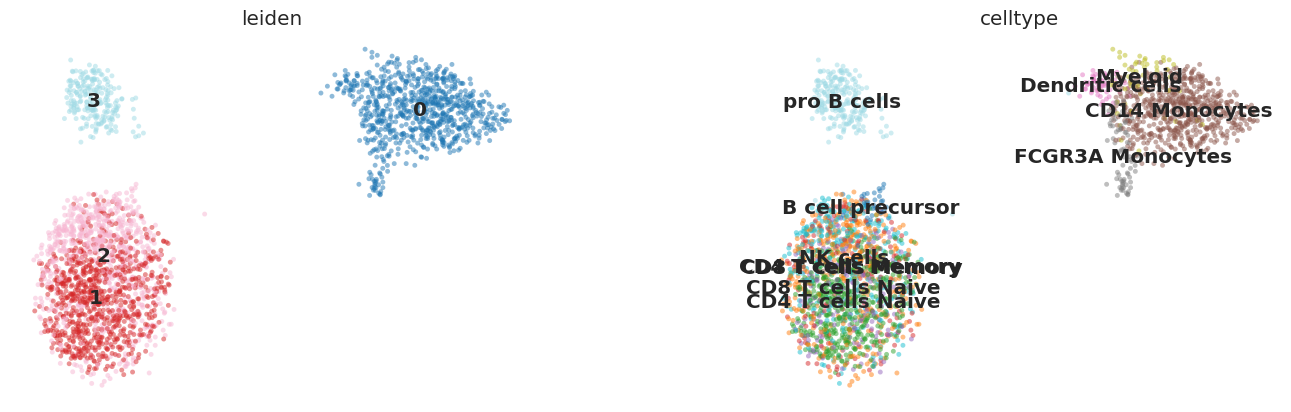

In [10]:
# Visualize leiden clusters and annotated cell types on the umap
sc.pl.umap(rna_ad, color=['leiden', 'celltype'], legend_loc='on data', ncols=2, wspace=0.3, hspace=0.3, frameon=False, size=50, alpha=0.5, palette='tab20')

# Diffusion maps

In [11]:
# Compute the diffusion components of the data using Palantir
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(rna_ad.obsm['X_pca']))

Determing nearest neighbor graph...


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


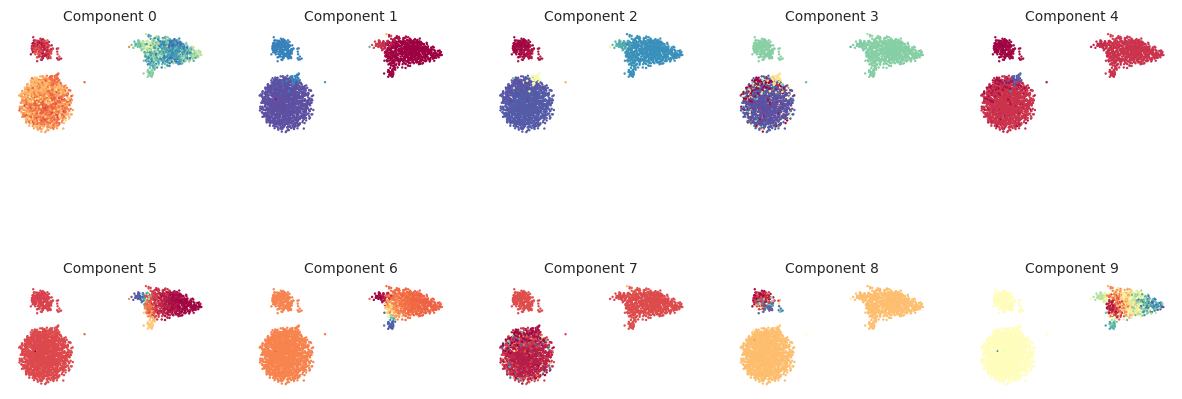

In [12]:
# Visualize the top 10 diffusion components on UMAP
umap = pd.DataFrame(rna_ad.obsm['X_umap'])
palantir.plot.plot_diffusion_components(umap, dm_res)

In [13]:
umap.to_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/umap.csv", index=False)

`Questions & Exercises`

1. Based on visual inspection, what are some of the obvious component to cell type association? 

Components 1, 4, 5, and 7.

2. Use each component as a classifier and measure the classification accuracy for each cell type. 
   Hint: Compute auROC using cell type labels and diffusion component projects. The result should be a heatmap with cell types on rows and diffusion components on the columns with the values indicating the classification accuracy.

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


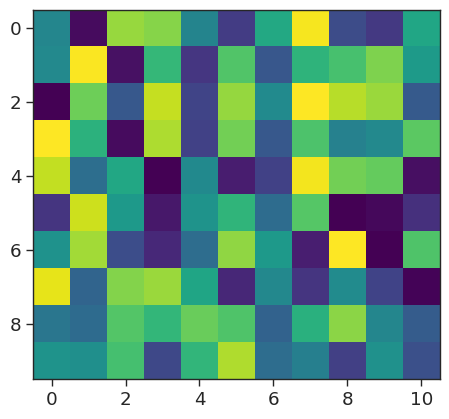

In [14]:
import sklearn
from sklearn.metrics import roc_auc_score

vals, mapping = rna_ad.obs["celltype"].factorize()

scores = np.zeros((10, 11))
for i in range(10):
    y_pred = dm_res["EigenVectors"][i]
    for j in range(11):
        y_true = (rna_ad.obs["celltype"].to_numpy() == mapping[j]).astype(int)
        scores[i][j] = roc_auc_score(y_true, y_pred)

plt.imshow(scores, cmap='viridis')

The next goal is to train a classifier for cell types using the embedded space. Please use the subset of cells `rna_ad.obs['train']` for training and predict on the remainder of the cells. You are free to use any classifier of your choice such as SVMs, logistic regression etc - a suggestion is to use absorbing markov chain by using the training cells as "terminal states". 

In [15]:
train = rna_ad[~rna_ad.obs["train"]].obs["celltype"].reset_index(drop=True)
train.value_counts()

CD14 Monocytes        567
CD4 T cells Naive     421
CD4 T cells Memory    340
NK cells              288
pro B cells           199
CD8 T cells Naive     163
CD8 T cells Memory    136
FCGR3A Monocytes       61
Dendritic cells        39
Myeloid                35
B cell precursor       32
Name: celltype, dtype: int64

In [16]:
test = rna_ad[rna_ad.obs["train"]].obs["celltype"].reset_index(drop=True)
test.value_counts()

CD4 T cells Memory    55
CD14 Monocytes        47
CD4 T cells Naive     46
pro B cells           25
NK cells              22
CD8 T cells Naive     20
CD8 T cells Memory    18
Myeloid               16
Dendritic cells       13
B cell precursor      11
FCGR3A Monocytes       8
Name: celltype, dtype: int64

In [17]:
train_pcs = dm_res["EigenVectors"][~rna_ad.obs["train"].reset_index(drop=True)].reset_index(drop=True)
train_pcs.columns = ["dim" + str(i) for i in range(1, 11)]

test_pcs = dm_res["EigenVectors"][rna_ad.obs["train"].reset_index(drop=True)].reset_index(drop=True)
test_pcs.columns = ["dim" + str(i) for i in range(1, 11)]

In [18]:
train = pd.concat([train, train_pcs], axis=1)
test = pd.concat([test, test_pcs], axis=1)

In [19]:
train.to_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/train.csv", index=False)
test.to_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/test.csv", index=False)

In [20]:
data = pd.DataFrame(rna_ad.X.toarray(), columns=rna_ad.var_names)
data.to_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/rna.csv", index=False)

In [21]:
rna_ad.obs["train"].to_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/train_mask.csv", index=False)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
np.random.seed(42)

2023-04-27 10:00:53.454722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/train.csv")
test = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/test.csv")

In [3]:
X_train = train[train.filter(regex='^dim').columns.tolist()].to_numpy()
X_test = test[test.filter(regex='^dim').columns.tolist()].to_numpy()

In [4]:
y_train, classes = train["celltype"].factorize()
class_to_int, int_to_class = {c:i for i, c in enumerate(classes)}, {i:c for i, c in enumerate(classes)}
y_test = test["celltype"].map(class_to_int).to_numpy()

In [5]:
tf.keras.backend.clear_session()

def build_classifier():
    inp = tf.keras.layers.Input(shape=(10,))
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(inp)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation=tf.keras.activations.swish)(inp)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(x)
    out = tf.keras.layers.Dense(11, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_classifier()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1408      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0     

2023-04-27 10:01:00.955343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/classifier.yaml', 
                                                monitor='val_loss', mode='min', verbose=False,
                                                save_best_only=True, save_weights_only=False)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.03, callbacks=[checkpoint], shuffle=True)

In [8]:
model = tf.keras.models.load_model('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/classifier.yaml')

In [9]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 0.2700 - accuracy: 0.8861


[0.2699560523033142, 0.8861209750175476]

In [10]:
import sklearn
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test).argmax(axis=1), target_names=list(classes)))

9/9 [==============================] - 0s 1ms/step
                    precision    recall  f1-score   support

          NK cells       1.00      1.00      1.00        22
    CD14 Monocytes       0.98      1.00      0.99        47
 CD4 T cells Naive       0.73      0.96      0.83        46
  B cell precursor       1.00      1.00      1.00        11
 CD8 T cells Naive       0.22      0.10      0.14        20
           Myeloid       1.00      0.88      0.93        16
CD4 T cells Memory       0.87      0.85      0.86        55
       pro B cells       1.00      1.00      1.00        25
   Dendritic cells       1.00      1.00      1.00        13
  FCGR3A Monocytes       1.00      1.00      1.00         8
CD8 T cells Memory       0.94      0.89      0.91        18

          accuracy                           0.89       281
         macro avg       0.89      0.88      0.88       281
      weighted avg       0.87      0.89      0.87       281



In [11]:
sklearn.metrics.confusion_matrix(y_test, model.predict(X_test).argmax(axis=1))

9/9 [==============================] - 0s 1ms/step


array([[22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 44,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 13,  0,  2,  0,  5,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0, 14,  0,  0,  0,  0,  1],
       [ 0,  0,  3,  0,  5,  0, 47,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 25,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0, 16]])

1. What is the overall classification accuracy? 

Over 97% when on 50 principal components, About 89% when on the 10 diffusion components.

2. What is the classification accuracy per cell type?

Shown Above

3. Are some cell types easier to classify - if not, why not?

Yes, some cell types are easier to classify. Some cells are more similar to other cell types, so there is more confusion between them. There is also a large data imbalance, making it even harder to classify.

# Autoencoders for single cell data

Here, you will build an autoencoder for modeling the 10X PBMC single-cell data. 
* You are free to use any "variant" of the autoencoder we discussed: Contractive/Denoising/Variational
* Can start from normalized data or raw counts with an appropriate loss function
* The number of hidden layers or general architectural design is up to your discretion 
* Build the model with latent space dimension = 10

Please provide a small explanation for your final modeling choices and why you made them

I made an autoencoder with the encoder containing 3 hidden layers of 512, 256, and 64 nodes respectively. I chose these numbers because they are smaller than the number of features, but still large enough to capture the complexity of the data. I also added dropout so the model does completely overfit.

In [12]:
data = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/rna.csv")
data.head()

,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,HES4,ISG15,C1orf159,TNFRSF18,TNFRSF4,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1,AC007325.4,AC004556.1
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,3.909221,...,8.457817,7.403361,4.860392,7.816267,7.142030,0.0,7.403361,0.0,0.0,0.000000
1,0.0,0.0,0.0,2.480003,0.000000,0.0,0.0,0.0,0.0,0.000000,...,7.594828,8.308111,0.000000,6.532625,4.831569,0.0,7.488487,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000,3.390706,0.0,0.0,0.0,0.0,0.000000,...,7.342526,7.342526,0.000000,7.712473,4.320236,0.0,7.163138,0.0,0.0,3.390706
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,7.855499,7.071527,3.715554,7.516122,4.659572,0.0,7.310884,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,7.858373,7.780716,0.000000,7.074391,3.718221,0.0,6.208816,0.0,0.0,0.000000


In [14]:
data = data.to_numpy()
data.shape

(2562, 11865)

In [15]:
norm_data = data / np.linalg.norm(data)

In [13]:
tf.keras.backend.clear_session()

def build_autoencoder():
    inp = tf.keras.layers.Input(shape=(11865,))
    x = tf.keras.layers.Dense(512, activation=tf.keras.activations.swish)(inp)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(10, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(x)
    out = tf.keras.layers.Dense(11865, activation='relu')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

model = build_autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11865)]           0         
                                                                 
 dense (Dense)               (None, 512)               6075392   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

In [ ]:
model.fit(norm_data, data, epochs=100, batch_size=32, shuffle=True)

In [17]:
encoder = tf.keras.Model(inputs=model.input, outputs=model.layers[7].output)
projections = encoder.predict(norm_data)

81/81 [==============================] - 0s 5ms/step


In [18]:
import pickle as pkl

with open('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/projections.pkl','wb') as f:
    pkl.dump(projections, f)

/Users/tgoel/anaconda3/envs/ml_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


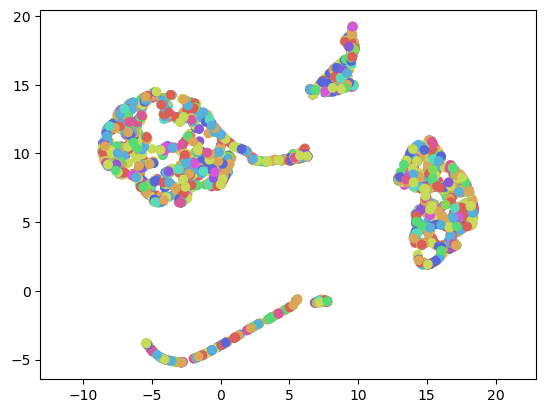

In [19]:
# Compute a UMAP using the autoencoder latent space 

import umap
import matplotlib.pyplot as plt
import seaborn as sns

umapp = umap.UMAP(n_components=2, random_state=42).fit_transform(projections)
colors = sns.color_palette("hls", 11)
labels = pd.concat([train["celltype"], test["celltype"]]).map(class_to_int).to_list()

plt.scatter(umapp[:, 0], umapp[:, 1], c=[colors[x] for x in labels])
plt.gca().set_aspect('equal', 'datalim')

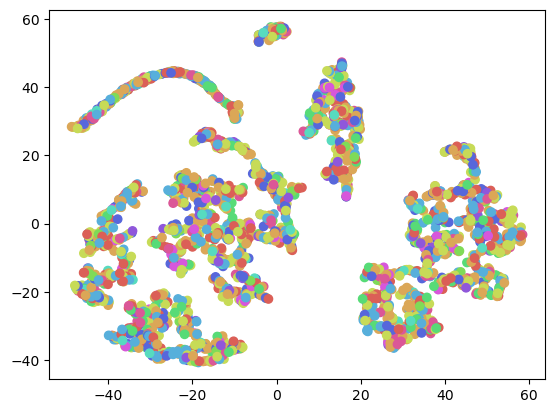

In [20]:
from sklearn.manifold import TSNE

res = TSNE(n_components=2, random_state=42).fit_transform(projections)
plt.scatter(res[:,0] , res[:,1], c=[colors[x] for x in pd.concat([train["celltype"], test["celltype"]]).map(class_to_int).to_list()])

What are your qualitative observations? How similar or different are the results to the UMAP computed using `PCA` above?

These maps are very different. It is hard to visualize the intermediate representation created by an autoencoder.

Perform the analysis listed for diffusion components using the autoencoder latent space and compare the results between autoencoders and diffusion maps

1. Visualize the latent space on UMAPs from PCA
2. Asses the classification performance of individual dimensions 
3. Train a classifier using the autoencoder latent space and compare results from diffusion maps

In [1]:
import pickle as pkl

with open('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/projections.pkl', 'rb') as f:
    projections = pkl.load(f)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


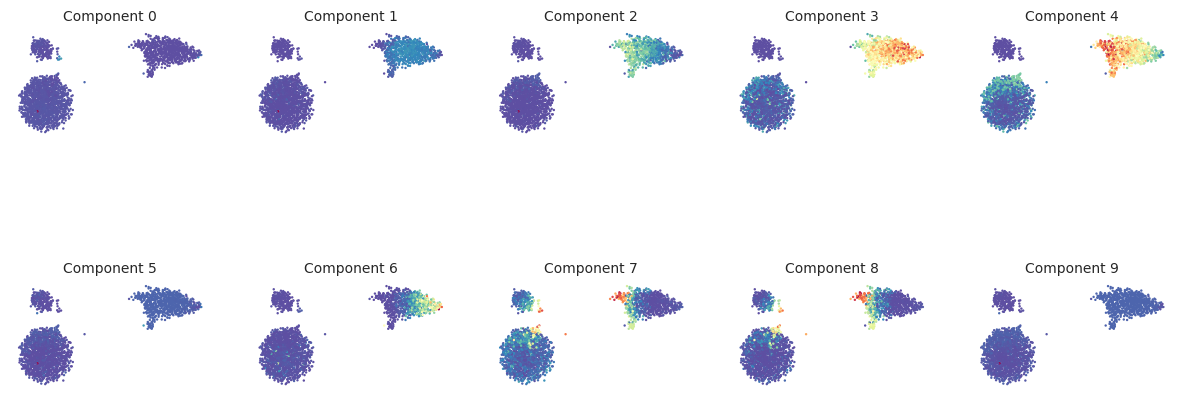

In [2]:
import scanpy as sc
import palantir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

umap = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/umap.csv")
palantir.plot.plot_diffusion_components(umap, {"EigenVectors": pd.DataFrame(projections)})

In [3]:
rna_ad = sc.read('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/pbmc_10x_subset.h5ad')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


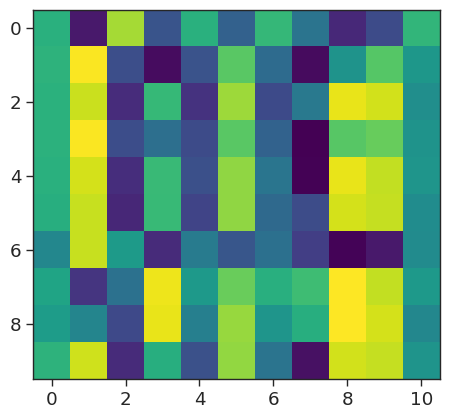

In [4]:
import sklearn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

vals, mapping = rna_ad.obs["celltype"].factorize()

scores = np.zeros((10, 11))
for i in range(10):
    y_pred = projections[:, i]
    for j in range(11):
        y_true = (rna_ad.obs["celltype"].to_numpy() == mapping[j]).astype(int)
        scores[i][j] = roc_auc_score(y_true, y_pred)

plt.imshow(scores, cmap='viridis')

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
np.random.seed(42)

2023-04-27 10:17:21.874501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pickle as pkl

with open('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/projections.pkl', 'rb') as f:
    projections = pkl.load(f)

In [3]:
train = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/train.csv")
test = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/test.csv")

In [4]:
y_train, classes = train["celltype"].factorize()
class_to_int, int_to_class = {c:i for i, c in enumerate(classes)}, {i:c for i, c in enumerate(classes)}
y_test = test["celltype"].map(class_to_int).to_numpy()
del train, test

In [5]:
train_mask = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/train_mask.csv").to_numpy()

In [6]:
X_train = pd.DataFrame(projections)[~train_mask]
X_test = pd.DataFrame(projections)[train_mask]

In [7]:
tf.keras.backend.clear_session()

def build_classifier2():
    inp = tf.keras.layers.Input(shape=(10,))
    x = tf.keras.layers.Dense(512, activation=tf.keras.activations.swish, name='d1')(inp)
    x = tf.keras.layers.Dropout(0.1, name='do1')(x)
    x = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish, name='d2')(x)
    x = tf.keras.layers.Dropout(0.2, name='do2')(x)
    x = tf.keras.layers.Dense(128, activation=tf.keras.activations.swish, name='d3')(x)
    x = tf.keras.layers.Dropout(0.1, name='do3')(x)
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish, name='d4')(x)
    out = tf.keras.layers.Dense(11, activation='softmax', name='output')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_classifier2()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 d1 (Dense)                  (None, 512)               5632      
                                                                 
 do1 (Dropout)               (None, 512)               0         
                                                                 
 d2 (Dense)                  (None, 256)               131328    
                                                                 
 do2 (Dropout)               (None, 256)               0         
                                                                 
 d3 (Dense)                  (None, 128)               32896     
                                                                 
 do3 (Dropout)               (None, 128)               0     

2023-04-27 10:17:24.447762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/_classifier_.yaml', 
                                                monitor='val_loss', mode='min',
                                                save_best_only=True, save_weights_only=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.03, callbacks=[checkpoint], shuffle=True)

In [11]:
model.load_weights('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw4/_classifier_.yaml')

In [12]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8932


[0.35911044478416443, 0.8932384252548218]